In [1]:
# Import of relevant packages
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.model_selection import GridSearchCV,cross_val_score,RandomizedSearchCV,  train_test_split, cross_val_predict


#from scipy.stats import randint
RSEED = 45
#pip install forestci
#import forestci as fci

In [2]:
df = pd.read_csv('datasets/kickstarter/kickstarter_cleaned.csv')
df1 = df.copy()
#df1
#df.head()

In [3]:
y = df1["outcome"].astype(str)
X = df1 .loc[:, df1. columns != "outcome"].astype(str)
#print('Input', X.shape)
#print('Output', y.shape)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

In [5]:
## Predictive Modelling using Pipelines and Grid Search

In [6]:
# from sklearn.impute import SimpleImputer, optional in case of missing data

cat_attribs = ['category', 'subcategory', 'country']
num_attribs = ['yr_launched', 'duration_days','goal']

num_pipeline = make_pipeline( #SimpleImputer(strategy="median"),
    StandardScaler())

cat_pipeline = make_pipeline(
    #SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [7]:
# extra code – shows that we can get a DataFrame out if we want
#df1_1hot = preprocessing.fit_transform(df1)
#df1_1hot.toarray()
#print(df1_1hot.shape)
#(331462, 199)


#onehot_feature_names = OneHotEncoder.get_feature_names_out(df1.columns)
#onehot_df = pd.DataFrame(df1_1hot, columns=onehot_feature_names)
# Concatenating the original DataFrame (dropping the original categorical columns) with the new one-hot encoded DataFrame
#df1_combined = pd.concat([df1.drop(columns=df1.columns), onehot_df], axis=1)
#df1_combined


In [8]:
# Building a full pipeline with our preprocessor and a LogisticRegression Classif
pipe_logreg = Pipeline([
    ('preprocessor', preprocessing),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [9]:
### Optimizing via Grid Search

In [10]:
# Defining parameter space for grid-search. Since we want to access the classifier step (called 'logreg') in our pipeline 
# we have to add 'logreg__' in front of the corresponding hyperparameters. 
param_logreg = {'logreg__penalty':('l1','l2'),
                'logreg__C': [0.001, 0.01, 0.1, 1, 10],
                'logreg__solver': ['liblinear', 'lbfgs', 'sag']
               }
grid_logreg = GridSearchCV(pipe_logreg, param_grid=param_logreg, cv=5, scoring='accuracy', 
                           verbose=5, n_jobs=-1)

In [ ]:
grid_logreg.fit(X_train, y_train)

In [12]:
print("Best parameters:\n{}".format(grid_logreg.best_params_))

Best parameters:
{'logreg__C': 10, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


In [13]:
# Save best model (including fitted preprocessing steps) as best_model 
best_model = grid_logreg.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['yr_launched',
                                                   'duration_days', 'goal']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['category', 'subcategory',
                                                   'country'])])),
                ('logreg',
                 LogisticRegression(C=10, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

In [14]:
y_pred_train = best_model.predict(X_train)
print(classification_report(y_pred_train, y_train))

              precision    recall  f1-score   support

           0       0.80      0.69      0.74    183837
           1       0.47      0.62      0.53     81332

    accuracy                           0.67    265169
   macro avg       0.64      0.66      0.64    265169
weighted avg       0.70      0.67      0.68    265169



In [15]:
y_pred = best_model.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.80      0.69      0.74     45892
           1       0.47      0.62      0.53     20401

    accuracy                           0.67     66293
   macro avg       0.64      0.65      0.64     66293
weighted avg       0.70      0.67      0.68     66293



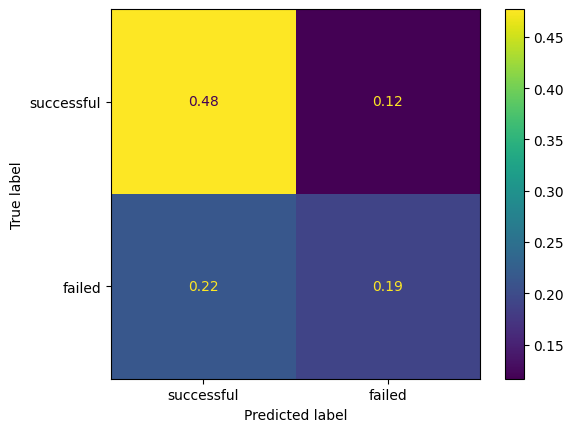

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['successful','failed'])
cmd.plot()